# Part 1

In [133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns

import json

import time
from datetime import datetime
from datetime import timedelta

import networkx as nx

from statsmodels import api as sm
import warnings
warnings.filterwarnings('ignore')

## Data Import

In [2]:
train_data = pd.read_csv('train.csv')
train_data.shape

(5500, 23)

In [3]:
train_data.columns

Index(['Choice', 'A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

In [4]:
y = train_data['Choice']
X = train_data.drop('Choice', axis = 1)

In [5]:
test_data = pd.read_csv('test.csv')
test_data.shape

(5952, 22)

In [6]:
test_data.columns

Index(['A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3'],
      dtype='object')

In [7]:
y.value_counts()

1    2802
0    2698
Name: Choice, dtype: int64

## Data Preprocessing

### 1. Transformation : Dividing(A/B)
### 2. Transformation : Difference (A>B)

In [8]:
def transformations(data):
    data['A_pop_ratio'] = data['A_mentions_sent']/(data['A_listed_count'] + 0.001)
    data['A_foll_ratio'] = data['A_follower_count']/(data['A_following_count'] + 0.001)
    data['A_ment_ratio'] = data['A_mentions_sent']/(data['A_mentions_received'] + 0.001)
    data['A_rt_ratio'] = data['A_retweets_sent']/(data['A_retweets_received'] + 0.001)

    data['B_pop_ratio'] = data['B_mentions_sent']/(data['B_listed_count'] + 0.001)
    data['B_foll_ratio'] = data['B_follower_count']/(data['B_following_count'] + 0.001)
    data['B_ment_ratio'] = data['B_mentions_sent']/(data['B_mentions_received'] + 0.001)
    data['B_rt_ratio'] = data['B_retweets_sent']/(data['B_retweets_received'] + 0.001)
    
    # Transforming A and B variables -- A > B
    data['A-B_follower_count'] = (data['A_follower_count'] > data['B_follower_count'])
    data['A-B_following_count'] = (data['A_following_count'] > data['B_following_count'])
    data['A-B_listed_count'] = (data['A_listed_count'] > data['B_listed_count'])
    data['A-B_mentions_received'] = (data['A_mentions_received'] > data['B_mentions_received'])
    data['A-B_retweets_received'] = (data['A_retweets_received'] > data['B_retweets_received'])
    data['A-B_mentions_sent'] = (data['A_mentions_sent'] > data['B_mentions_sent'])
    data['A-B_retweets_sent'] = (data['A_retweets_sent'] > data['B_retweets_sent'])
    data['A-B_posts'] = (data['A_posts'] > data['B_posts'])
    data['A-B_network_feature_1'] = (data['A_network_feature_1'] > data['B_network_feature_1'])
    data['A-B_network_feature_2'] = (data['A_network_feature_2'] > data['B_network_feature_2'])
    data['A-B_network_feature_3'] = (data['A_network_feature_3'] > data['B_network_feature_3'])
    data['A-B_foll_ratio'] = (data['A_foll_ratio'] > data['B_foll_ratio'])
    data['A-B_ment_ratio'] = (data['A_ment_ratio'] > data['B_ment_ratio'])
    data['A-B_rt_ratio'] = (data['A_rt_ratio'] > data['B_rt_ratio'])
    
    return data

In [9]:
X_t = transformations(X)

sub_cols = ['A-B_follower_count',
'A-B_following_count',
'A-B_listed_count',
'A-B_mentions_received',
'A-B_retweets_received',
'A-B_mentions_sent',
'A-B_retweets_sent',
'A-B_posts',
'A-B_network_feature_1',
'A-B_network_feature_2',
'A-B_network_feature_3',
'A-B_foll_ratio',
'A-B_ment_ratio',
'A-B_rt_ratio']

<AxesSubplot:>

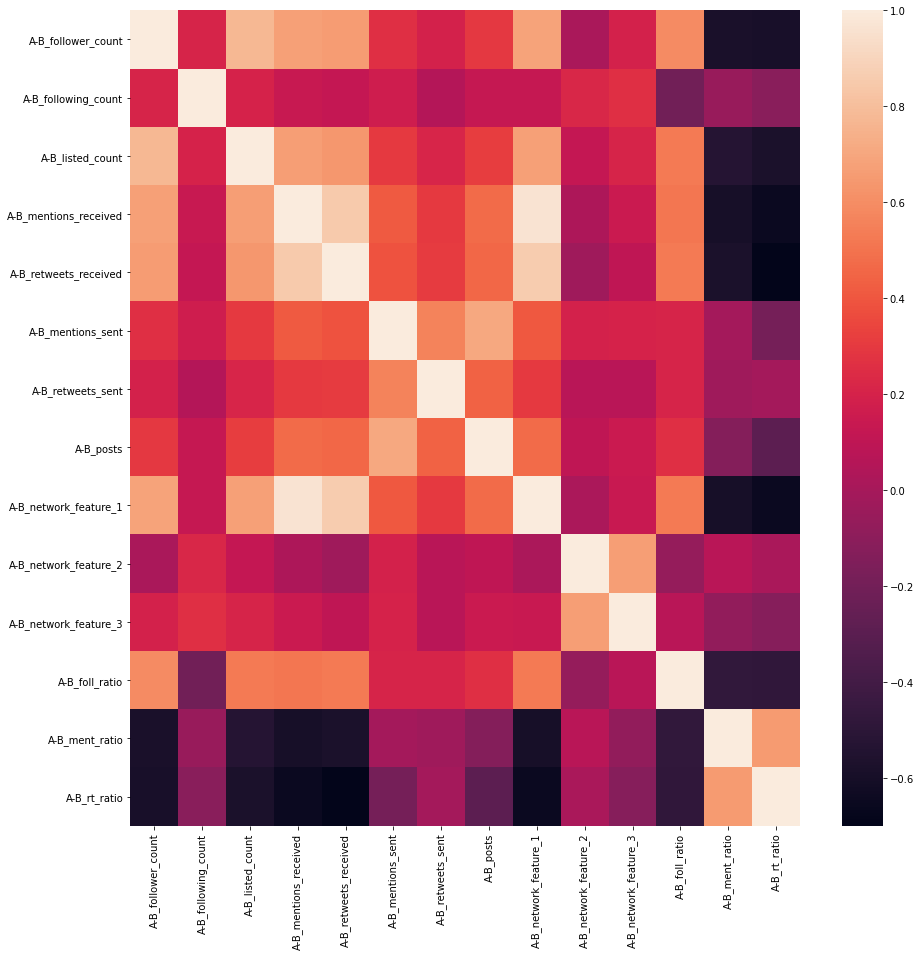

In [10]:
Var_Corr = X_t[sub_cols].corr()

plt.figure(figsize=(15,15))
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

### Variance Inflation factor to filter out highly correlated features

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = X_t[sub_cols]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

In [12]:
vif_data

,feature,VIF
0,A-B_follower_count,0.002443
1,A-B_following_count,0.000927
2,A-B_listed_count,0.002096
3,A-B_mentions_received,0.009857
4,A-B_retweets_received,0.003202
5,A-B_mentions_sent,0.001849
6,A-B_retweets_sent,0.001215
7,A-B_posts,0.001602
8,A-B_network_feature_1,0.010381
9,A-B_network_feature_2,0.001411


In [13]:
selected_cols = vif_data[vif_data['VIF'] <= 5]['feature'].values.tolist()

In [14]:
selected_cols

['A-B_follower_count',
 'A-B_following_count',
 'A-B_listed_count',
 'A-B_mentions_received',
 'A-B_retweets_received',
 'A-B_mentions_sent',
 'A-B_retweets_sent',
 'A-B_posts',
 'A-B_network_feature_1',
 'A-B_network_feature_2',
 'A-B_network_feature_3',
 'A-B_foll_ratio',
 'A-B_ment_ratio',
 'A-B_rt_ratio']

## Running different models on difference transformations

In [211]:
X_train, X_val, y_train, y_val = train_test_split(X[selected_cols], y, test_size=0.3, random_state=42)

In [212]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7787878787878788

In [213]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7412121212121212

In [214]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7496969696969698

In [215]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7406060606060606

In [216]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

[20:31:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7503030303030302

In [217]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7636363636363637

In [218]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7709090909090909

All models performed equally well

#### CV and hyper parameter Tuning for Logistic regression

In [219]:
# Number of trees in random forest
penalty = ['l1', 'l2', 'elasticnet', 'none']
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
gamma = [0.001, 0.0001]
kernel = ['rbf']
param_grid = {'solver': solvers,
               'penalty': penalty,
               'C': c_values} 

model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv = 10,
                           n_jobs=-1,
                          verbose=3)


In [220]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=3)

In [221]:
log_reg_best = grid_search.best_estimator_
log_reg_best.fit(X_train, y_train)
y_pred = log_reg_best.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7763636363636364

#### CV and Hyperparameter tuning for RF 

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=3, 
    random_state=42,
    scoring = 'accuracy',
    n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring='accuracy', verbose=3)

In [35]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [36]:
rf_best = rf_random.best_estimator_

In [37]:
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_val)
accuracy_score(y_pred=y_pred, y_true=y_val)

0.7636363636363637

**Logistic regression performed the best with ~78% accuracy**

In [252]:
log_reg_best.fit(X_train, y_train)
y_pred = log_reg_best.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_pred=y_pred, y_true=y_val).ravel()

## Financial value of the model

If an influencer tweets once, there is a 0.01% chance that his/her followers will buy one unit of a product. Assume the retailer has a profit margin of \\$10 per unit, and that one customer can buy only one unit. If an influencer tweets twice, the overall buying probability will be 0.015\% Without analytics, the retailer offers \\$5 to each person (A and B) to tweet once. With analytics, the retailer offers \\$10 to those identified as influencer by the model to send two tweets each.

In [253]:
## choice for retailers based on follower count of a user
y_val_ix = y_val.index
val_data = train_data.iloc[y_val_ix]
profit_from_A = sum(0.0001 * val_data['A_follower_count'] * val_data['Choice']*10) - 5*sum(val_data['Choice'])
profit_from_B = sum(0.0001 * val_data['B_follower_count'] * (val_data['Choice']==0)*10) - 5*sum(val_data['Choice']==0)

In [254]:
profit_from_B

887292.7939999972

In [255]:
total_profit_wo_targeting = profit_from_A + profit_from_B
total_profit_wo_targeting

1697597.578999997

In [256]:
## Profit via targeting
profit_targeting_A = sum(0.00015 * val_data['A_follower_count']*y_val*y_pred*10) - 10*sum(y_pred)
profit_targeting_B = sum(0.00015 * val_data['B_follower_count']*(y_val == 0)*(y_pred == 0)*10) - 10*sum(y_pred==0)

total_profit_with_targeting = profit_targeting_A + profit_targeting_B
total_profit_with_targeting

2394016.8675000006

In [257]:
profit_increase = (total_profit_with_targeting - total_profit_wo_targeting) / total_profit_wo_targeting * 100

In [258]:
lift1 = total_profit_with_targeting - total_profit_wo_targeting
lift1

696419.2885000037

### Financial Lift of our model

In [259]:
#financial lift 
print(f'The financial lift from using our analytical model after identifying influencers : {round(lift1,2)}')

The financial lift from using our analytical model after identifying influencers : 696419.29


In [260]:
print(f'Percentage increase in profit after identifying influencers : {round(profit_increase,2)}%')

Percentage increase in profit after identifying influencers : 41.02%


### Financial Lift of Perfect Model

In [261]:
## Profit via targeting
profit_perfect_A = sum(0.00015 * val_data['A_follower_count']*val_data['Choice']*10) - 10*sum(val_data['Choice'])
profit_perfect_B = sum(0.00015 * val_data['B_follower_count']*(val_data['Choice'] == 0)*10) - 10*sum(val_data['Choice'])

total_profit_perfect = profit_perfect_A + profit_perfect_B
total_profit_perfect

2542171.3685000017

In [262]:
lift2 = total_profit_perfect - total_profit_wo_targeting

profit_increase2 = (total_profit_perfect - total_profit_wo_targeting) / total_profit_wo_targeting * 100

In [263]:
#financial lift 
print(f'The financial lift for a perfect analytical model : {round(lift2,2)}')

The financial lift for a perfect analytical model : 844573.79


In [264]:
print(f'Percentage increase in profit using perfect analytical model : {round(profit_increase2,2)}%')

Percentage increase in profit using perfect analytical model : 49.75%


## Part 2

In [57]:
import requests
import json
import time
from tokens import api_key, api_secret_key, access_token, access_secret_token, bearer_token
from collections import defaultdict

In [58]:
def create_fields(keyword, start_date, end_date, max_results = 10):
    
    search_url = 'https://api.twitter.com/2/tweets/search/recent'
    
    headers = {
        'Authorization': 'Bearer {bearer_token}',
    }

    params = {'query': keyword,
                'start_time': start_date,
                'end_time': end_date,
                'max_results': max_results,
                'expansions': 'author_id,in_reply_to_user_id,geo.place_id,referenced_tweets.id,referenced_tweets.id.author_id',
                'tweet.fields': 'context_annotations,id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                'poll.fields' : 'duration_minutes,end_datetime,id,options,voting_status',
                'next_token': {}}
    
    return search_url, headers, params

In [59]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.get(url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json(), params

In [62]:
#WearADamnMask #covidiots #antivaxxers

keyword = " #antivaxxers"
start_time = "2022-02-03T16:00:00Z"
end_time = "2022-02-03T17:00:00Z"
max_results = 50

search_url, headers, query_params = create_fields(keyword, start_time, end_time, max_results)

count = 0

tweets_list = []
users_list = []
data_list = []
while True:
    print(f"Token :{query_params['next_token']}, tweets count : {len(tweets_list)}, users count : {len(users_list)}, data count : {len(data_list)}")
    
    try:
        json_response, query_params = connect_to_endpoint(search_url, headers, query_params)
    except Exception as e:
        print(e)
        break
        
    users = json_response['includes']['users']
    tweets = json_response['includes']['tweets']
    data = json_response['data']
    
    for d in data:
        data_dict = defaultdict()
        data_dict['tweet_id'] = d['id']
        data_dict['author_id'] = d['author_id']
        data_dict['text'] = d['text']
        data_dict['created_at'] = d['created_at']
        data_dict['like_count'] = d['public_metrics']['like_count']
        data_dict['retweet_count'] = d['public_metrics']['retweet_count']
        try:
            data_dict['referenced_tweets'] = d['referenced_tweets']
        except:
            pass
        
        data_list.append(data_dict)
    
    for user in users:
        user_dict = {
            'username' : user['username'],
            'followers_count' : user['public_metrics']['followers_count'],
            'following_count' : user['public_metrics']['following_count'],
            'user_tweet_count' : user['public_metrics']['tweet_count'],
            'listed_count' : user['public_metrics']['listed_count'],
            'description' : user['description'],
            'user_id' : user['id']
        }
        users_list.append(user_dict)
        
    for tweet in tweets:
        tweet_dict = {
            'text' : tweet['text'],
            'like_count' : tweet['public_metrics']['like_count'],
            'retweet_count' : tweet['public_metrics']['retweet_count'],
            'created_at' : tweet['created_at'],
            'tweet_id' : tweet['id'],
            'author_id' : tweet['author_id']
        } 
        
        tweets_list.append(tweet_dict)
    

    start_datetime = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
    start_datetime = start_datetime + timedelta(hours = 1)
    end_datetime = start_datetime + timedelta(hours = 1)
    
    start_time = start_datetime.strftime("%Y-%m-%dT%H:%M:%SZ")
    end_time = end_datetime.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    query_params['start_time'] = start_time
    query_params['end_time'] = end_time
    
    count+=max_results
    
    print("----------- Sleeping for 100 seconds ---------")
    time.sleep(310)
    
    if count == 10000:
        break

Token :{}, tweets count : 0, users count : 0, data count : 0
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 25, users count : 57, data count : 48
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 34, users count : 114, data count : 98
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 43, users count : 157, data count : 148
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 58, users count : 202, data count : 195
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 77, users count : 251, data count : 244
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 94, users count : 296, data count : 294
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :No

Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1283, users count : 2945, data count : 2774
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1312, users count : 2990, data count : 2824
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1335, users count : 3052, data count : 2874
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1369, users count : 3114, data count : 2923
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1397, users count : 3176, data count : 2971
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1426, users count : 3242, data count : 3020
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 1453, users cou

Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2437, users count : 6150, data count : 5455
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2446, users count : 6208, data count : 5505
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2461, users count : 6267, data count : 5555
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2478, users count : 6328, data count : 5605
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2490, users count : 6382, data count : 5654
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2509, users count : 6445, data count : 5704
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 2532, users cou

Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3602, users count : 8965, data count : 7679
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3626, users count : 9031, data count : 7729
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3651, users count : 9098, data count : 7779
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3676, users count : 9160, data count : 7829
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3709, users count : 9231, data count : 7879
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3737, users count : 9301, data count : 7927
Endpoint Response Code: 200
----------- Sleeping for 100 seconds ---------
Token :None, tweets count : 3762, users cou

KeyError: 'includes'

In [63]:
data_df = pd.DataFrame(data_list)

In [64]:
reference_list = []
for i, t in zip(data_df['referenced_tweets'], data_df['tweet_id']):
    if not isinstance(i, float):
        for j in i:
            reference_list.append({
                'tweet_id' : t,
                'type' : j['type'],
                'reference_tweet_id' : j['id']
                })

In [65]:
reference_df = pd.DataFrame(reference_list)

In [84]:
users_df = pd.DataFrame(users_list)
users_df.sort_values('user_tweet_count', ascending=False)
users_df.drop_duplicates('username', keep='first', inplace = True)

In [95]:
tweets_df = pd.DataFrame(tweets_list)
print(tweets_df.shape)
tweets_df.sort_values(['like_count', 'retweet_count'], ascending=False)
tweets_df.drop_duplicates(['tweet_id', 'author_id'], keep='first', inplace=True)
print(tweets_df.shape)

(3784, 6)
(2067, 6)


In [97]:
data_df.to_csv('data.csv')
reference_df.to_csv('reference.csv')
tweets_df.to_csv('tweets.csv')
users_df.to_csv('users.csv')

## Data Preprocessing

In [109]:
# Define a function to find users whose tweets were retweeted
import re

def find_retweet(s):
    retweet = re.findall('RT \@[^\s\:]+',s)
    
    try:
        retweet = retweet[0][4:]
    except IndexError:
        retweet = None
    return retweet

In [117]:
users_df.columns

Index(['username', 'followers_count', 'following_count', 'user_tweet_count',
       'listed_count', 'description', 'user_id'],
      dtype='object')

In [120]:
users_data_df = pd.merge(left=data_df, right=users_df, right_on='user_id', left_on = 'author_id', how='left')

In [130]:
column_1 = users_data_df['username']
column_2 = users_data_df['text'].apply(lambda x : find_retweet(x))
tweet_data = pd.concat([column_1, column_2], axis=1)
tweet_data['Interaction'] = tweet_data['text'].apply(lambda x: 'Retweet' if x != None else 'Tweet')
tweet_data['text'] = tweet_data.apply(lambda row: row['username'] if row['text'] == None else row['text'],axis=1)
tweet_data.columns = ['User_A', 'User_B', 'Interaction']
tweet_data.head()

,User_A,User_B,Interaction
0,PolinaKovalen10,CarymaRules,Retweet
1,thesaraegray,michaelcoren,Retweet
2,MnSpenpal,UnKettled,Retweet
3,DonlasAdbe,DonlasAdbe,Tweet
4,The12fthOfNever,CarymaRules,Retweet


In [131]:
# Output CSV file

tweet_data.to_csv('users_interactions.csv')

## Visualizations the network

In [134]:
tweet_data['nodes'] = tweet_data[['User_A', 'User_B']].apply(tuple, axis=1)

g = nx.DiGraph()  
g.add_edges_from(tweet_data['nodes'])

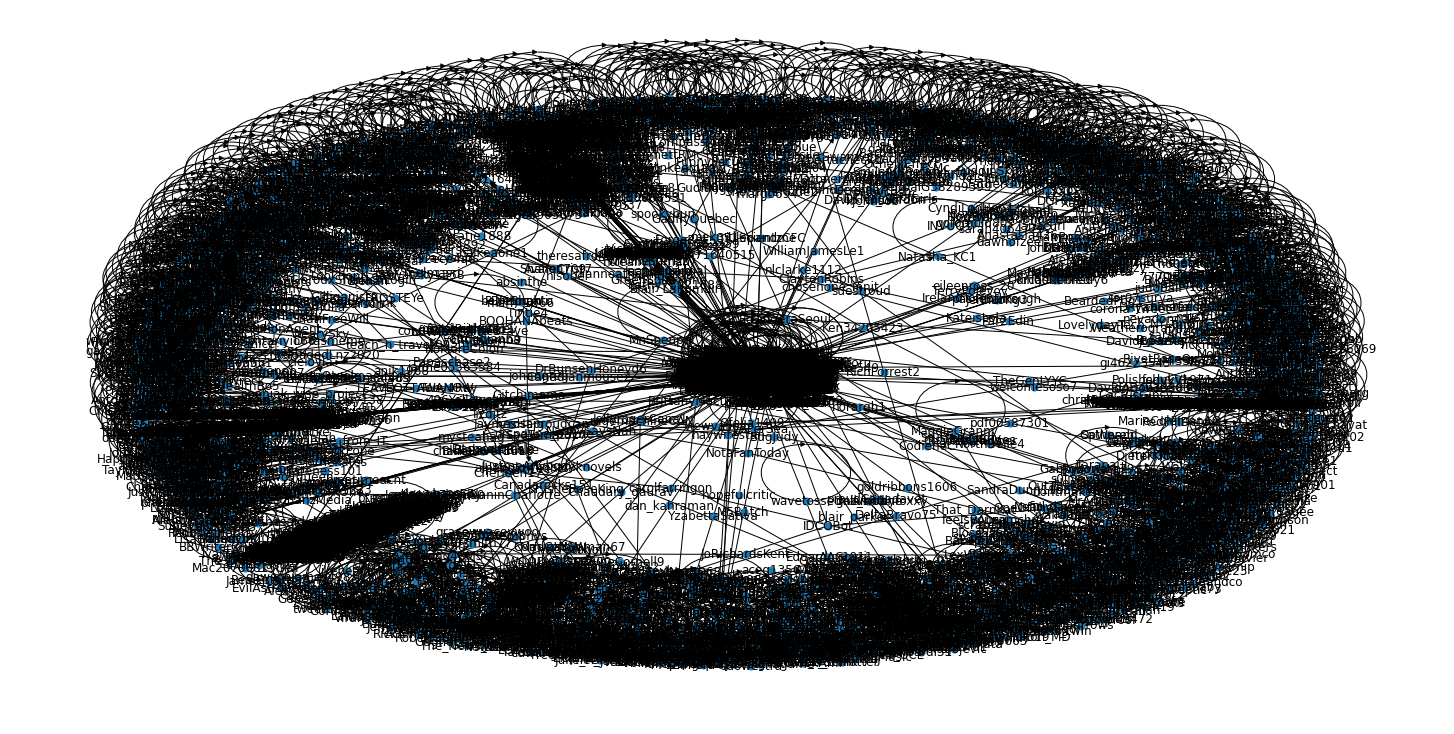

In [135]:
plt.figure(figsize = (20, 10))

nx.draw(g, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

### Network details and metrics

In [136]:
degree = nx.degree_centrality(g)
between = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)

In [139]:
metrics_df = pd.DataFrame([degree, between,close]).T
metrics_df.reset_index(inplace = True)
metrics_df.columns = ['username','degree','between','close']
metrics_df.head()

,username,degree,between,close
0,PolinaKovalen10,0.000176,0.000000,0.000000
1,CarymaRules,0.368152,0.000361,0.365834
2,thesaraegray,0.000176,0.000000,0.000000
3,michaelcoren,0.031883,0.000000,0.031564
4,MnSpenpal,0.000881,0.000000,0.000000


In [141]:
users_data_df = users_data_df.merge(metrics_df,how = 'inner', on = 'username')

In [249]:
user_a_retweets_tweets = pd.pivot_table(tweet_data[['User_A', 'User_B', 'Interaction']], 
                                        index = 'User_A', 
                                        columns = 'Interaction', 
                                        aggfunc = "count", 
                                        fill_value = 0).reset_index()

user_a_retweets_tweets.columns = user_a_retweets_tweets.columns.get_level_values(0)

user_a_retweets_tweets.columns = ['username', 'retweets_sent','tweet_count']

user_a_retweets_tweets.iloc[0]

username         07Cat31
retweets_sent          1
tweet_count            0
Name: 0, dtype: object

In [152]:
user_b_retweets_rec = pd.pivot_table(tweet_data[['User_A', 'User_B', 'Interaction']], index = 'User_B', columns = 'Interaction', 
                                     aggfunc = "count", fill_value = 0).reset_index()

user_b_retweets_rec.columns = user_b_retweets_rec.columns.get_level_values(0)
user_b_retweets_rec.columns = ['username', 'retweets_rec','tweet_count']

user_b_retweets_rec.drop('tweet_count', inplace = True, axis = 1)

# merge the two for the final results
retweets_df = user_a_retweets_tweets.merge(user_b_retweets_rec, how = 'outer', on='username').fillna(0)

In [250]:
# merge with other user data
final_df = users_data_df[['username', 'following_count', 'followers_count']].drop_duplicates().merge(retweets_df, how = 'left', on = 'username')

final_df.iloc[0]

username           PolinaKovalen10
following_count               1100
followers_count                874
retweets_sent                  2.0
tweet_count                    0.0
retweets_rec                   0.0
Name: 0, dtype: object

In [238]:
for i in final_df.iloc[:, 1:]:
  
    mean = final_df[i].mean()
    std = final_df[i].std()
    
    final_df[i] -= mean
    final_df[i] /= std

In [240]:
final_df.drop_duplicates(inplace=True)

# merge network stats with twitter stats
final_df2 = metrics_df.merge(final_df, on = "username")

final_df2.iloc[0]

username           PolinaKovalen10
degree                    0.000176
between                        0.0
close                          0.0
following_count          -0.185564
followers_count          -0.035343
retweets_sent             0.657237
tweet_count              -0.190208
retweets_rec              -0.02365
Name: 0, dtype: object

In [251]:
log_reg_coefs = pd.DataFrame({
    'coef' : log_reg_best.feature_names_in_,
    'val' : log_reg_best.coef_[0]
})

log_reg_coefs.iloc[0]

coef    A-B_follower_count
val               0.477257
Name: 0, dtype: object

## Finding Influencers

In [246]:
# Multiplying the metrics by logistic regeression coefficients to get the final score

final_df2['score'] = final_df2['followers_count']*log_reg_coefs.iloc[0]['val'] \
                    + final_df2['following_count']*log_reg_coefs.iloc[1]['val']\
                    + final_df2['retweets_sent']*log_reg_coefs.iloc[6]['val']\
                    + final_df2['retweets_rec']*log_reg_coefs.iloc[4]['val']\
                    + final_df2['tweet_count']*log_reg_coefs.iloc[7]['val']\
                    + final_df2['degree']*log_reg_coefs.iloc[8]['val']\
                    + final_df2['between']*log_reg_coefs.iloc[9]['val']\
                    + final_df2['close']*log_reg_coefs.iloc[10]['val']


In [248]:
final_df2.sort_values(by='score', ascending=False).head(50)

,username,degree,between,close,following_count,followers_count,retweets_sent,tweet_count,retweets_rec,score
1,CarymaRules,0.368152,3.608331e-04,0.365834,0.802477,0.296404,37.519846,27.850401,73.049469,38.857915
4843,CNNnews18,0.000176,0.000000e+00,0.000000,-0.315973,73.254051,-0.038284,-0.190208,-0.023650,34.834767
3195,raehanbobby,0.000176,0.000000e+00,0.000000,38.219847,7.902781,-0.038284,-0.190208,-0.023650,16.126150
97,DennisCardiff,0.000352,0.000000e+00,0.000000,28.670260,2.298222,0.657237,-0.190208,-0.023650,10.610713
539,viralvideovlogs,0.001761,0.000000e+00,0.000000,0.455952,0.089248,20.131822,-0.190208,-0.023650,7.479943
3203,mommamia1217,0.000176,0.000000e+00,0.000000,18.844895,2.268467,0.657237,-0.190208,-0.023650,7.414267
113,krismeloche,0.000352,0.000000e+00,0.000000,1.346463,0.089138,15.958697,-0.190208,-0.023650,6.254736
348,ActionTime,0.010569,8.658505e-06,0.010052,15.214689,1.374385,-0.038284,0.293251,1.385406,6.040099
2361,LaydenRobinson,0.000352,0.000000e+00,0.000000,16.744869,1.274400,-0.038284,0.293251,0.001071,6.021475
2266,progressivepush,0.000352,0.000000e+00,0.000000,15.245721,1.410794,-0.733805,0.293251,-0.023650,5.340628
